<b><font color="SteelBlue" size="+3">Classifiez automatiquement des biens de consommation</font></b>

# Introduction

Ce notebook est la suite de celui sur le traitement des descriptions. On récupère les données nettoyées pour les catégories des produits.

## Imports

In [1]:
# Chargement des librairies
# Standard
import os

# Data Manipulation and Analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from matplotlib.image import imread
from PIL import Image as PilImage

# Deep Learning - TensorFlow/Keras
os.environ["KERAS_BACKEND"] = "torch"
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inceptionresnetv2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet201
from tensorflow.keras.utils import to_categorical

# Custom Modules
from Deveau_Estelle_4_IMG_func_042024 import *

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'champagne_products.csv',
 'data',
 'Deveau_Estelle_1_notebook_txt_faisabilite_042024.ipynb',
 'Deveau_Estelle_2_NLP_func_042024.py',
 'Deveau_Estelle_3_notebook_img_faisabilite_042024.ipynb',
 'Deveau_Estelle_4_IMG_func_042024.py',
 'Deveau_Estelle_5_notebook_img_classification_042024.ipynb',
 'Deveau_Estelle_6_notebook_API_042024.ipynb',
 'exemple.jpg',
 'model_augmented_best.weights.h5',
 'model_augmented_data_best.weights.h5',
 'model_augmented_data_best_with_generator.weights.h5',
 'model_augmented_data_best_with_seq.weights.h5',
 'model_best.keras',
 'model_best.weights.h5',
 'model_densenet201_best.weights.h5',
 'model_inceptionresnetv2_best.weights.h5',
 'model_iresnetv2_ad_best.weights.h5',
 'model_vgg16_best.weights.h5',
 'OC_projet6.pptx',
 'pythonProject',
 'svg',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 'Weather_Images_CNN_Transfer_Learning_Stage_2_supervised_classification_V1.0.ipynb',
 '__pycache__']

In [3]:
os.listdir("data/Cleaned/")

['data.csv']

In [4]:
path     = "./data/Cleaned/"
filename = "data.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
path     = "./data/Sources/Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

1050


# Classification supervisée

In [7]:
cols_to_keep = ['uniq_id', 'product_category']
df = data[cols_to_keep]
df.head(5)

,uniq_id,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing


In [8]:
image_paths = [f"{path}{uid}.jpg" for uid in df['uniq_id']]

# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

## Séparation des jeux de données (train, val, test)

In [9]:
y = to_categorical(categories_encoded, 7)

In [10]:
y[:5]

array([[0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

In [11]:
# Diviser les chemins d'image et les étiquettes
paths_train, paths_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, random_state=42)
paths_train, paths_val, y_train, y_val = train_test_split(paths_train, y_train, test_size=0.25, random_state=42)

In [12]:
y_test[:5]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [13]:
# Dictionnaire pour stocker les résultats
results = {}

## Evaluation des modèles sélectionnés

In [14]:
# Définir le seuil à un niveau supérieur spécifique
PilImage.MAX_IMAGE_PIXELS = 100000000

### VGG16

In [15]:
# Préparation des données
X_train_vgg16, X_val_vgg16, X_test_vgg16 = prepare_data(paths_train, paths_val, paths_test, preprocess_vgg16,
                                                        target_size=(224, 224, 3))

In [16]:
# Création du modèle
model_vgg16 = create_model_fct(base_model_name='VGG16')

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2220 - loss: 8.4028
Epoch 1: val_loss improved from inf to 1.67563, saving model to ./model_vgg16_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2288 - loss: 8.3000 - val_accuracy: 0.7190 - val_loss: 1.6756
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6893 - loss: 2.2343
Epoch 2: val_loss improved from 1.67563 to 1.24564, saving model to ./model_vgg16_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.6900 - loss: 2.2292 - val_accuracy: 0.7714 - val_loss: 1.2456
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7665 - loss: 1.5812
Epoch 3: val_loss improved from 1.24564 to 1.19641, saving model to ./model_vgg16_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7663 - loss: 1.5818 - val_accuracy: 0.7952 - val_loss: 1.1964
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8015 - loss: 1.0657
Epoch 4: val_lo

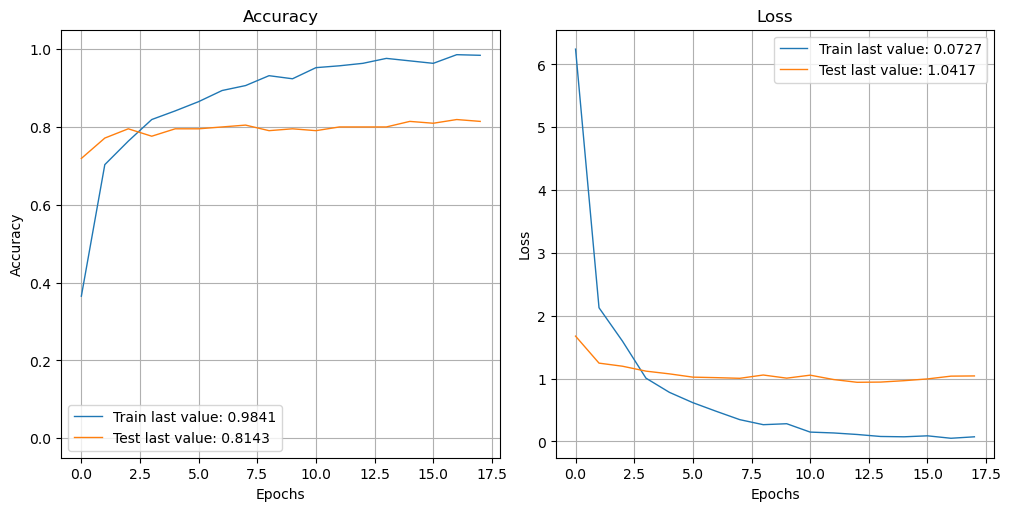

In [17]:
# Entraînement du modèle
model_vgg16, duration_vgg16 = train_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16, y_val,
                                          model_save_path="./model_vgg16_best.weights.h5")

In [18]:
# Évaluation du modèle
loss_vgg16, accuracy_vgg16, ari_score_vgg16 = evaluate_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16,
                                                             y_val, X_test_vgg16, y_test, best_weights_path="./model_vgg16_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0045
Training Accuracy after last epoch: 1.0000

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8323 - loss: 0.7300
Test Accuracy after last epoch: 0.8286

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7929 - loss: 1.0001
Validation Accuracy (best): 0.8000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8157 - loss: 0.7332
Test Accuracy (best): 0.8095
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Adjusted Rand Index (ARI): 0.6283


### InceptionResNetV2

In [19]:
# Préparation des données
X_train_inceptionresnetv2, X_val_inceptionresnetv2, X_test_inceptionresnetv2 = prepare_data(paths_train, paths_val,
                                                                                            paths_test, preprocess_inceptionresnetv2,
                                                                                            target_size=(299, 299, 3))

In [20]:
# Création du modèle
model_inceptionresnetv2 = create_model_fct(base_model_name='InceptionResNetV2')

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4126 - loss: 1.5826
Epoch 1: val_loss improved from inf to 0.50813, saving model to ./model_inceptionresnetv2_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.4204 - loss: 1.5655 - val_accuracy: 0.8619 - val_loss: 0.5081
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8525 - loss: 0.5235
Epoch 2: val_loss improved from 0.50813 to 0.48705, saving model to ./model_inceptionresnetv2_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.8521 - loss: 0.5242 - val_accuracy: 0.8143 - val_loss: 0.4870
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8525 - loss: 0.4688
Epoch 3: val_loss improved from 0.48705 to 0.40828, saving model to ./model_inceptionresnetv2_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.8529 - loss: 0.4683 - val_accuracy: 0.8524 - val_loss: 0.4083
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0

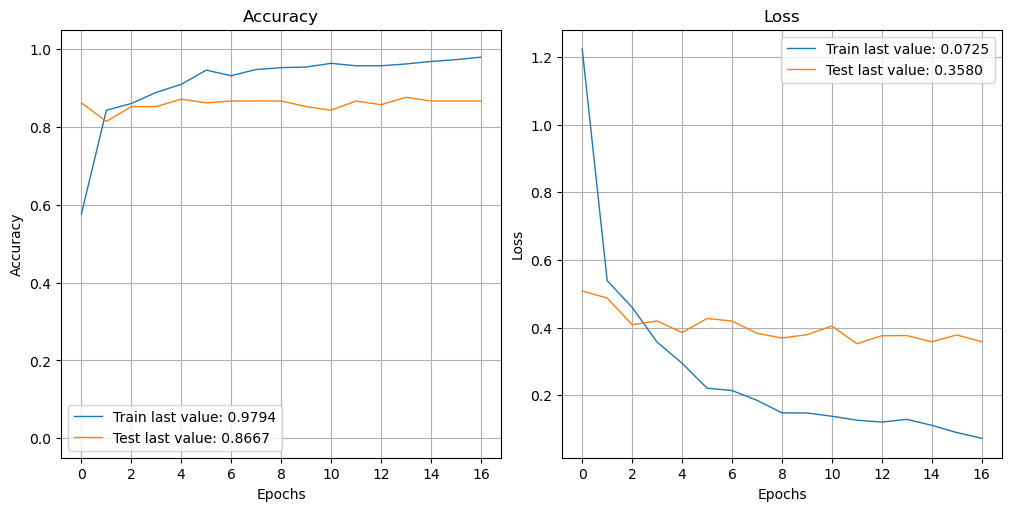

In [21]:
# Entraînement du modèle
model_iresnetv2, duration_iresnetv2 = train_model(model_inceptionresnetv2, X_train_inceptionresnetv2,
                                                  y_train, X_val_inceptionresnetv2, y_val,
                                                  model_save_path="./model_inceptionresnetv2_best.weights.h5")

In [22]:
# Évaluation du modèle
loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2 = evaluate_model(model_iresnetv2,
                                                                                                 X_train_inceptionresnetv2,
                                                                                                 y_train, X_val_inceptionresnetv2,
                                                                                                 y_val, X_test_inceptionresnetv2,
                                                                                                 y_test,
                                                                                                 best_weights_path="./model_inceptionresnetv2_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.9917 - loss: 0.0358
Training Accuracy after last epoch: 0.9921

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.9047 - loss: 0.4119
Test Accuracy after last epoch: 0.8905

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.8590 - loss: 0.3604
Validation Accuracy (best): 0.8667
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.8786 - loss: 0.4290
Test Accuracy (best): 0.8810
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
Adjusted Rand Index (ARI): 0.7589


### DenseNet201

In [23]:
# Préparation des données
X_train_densenet201, X_val_densenet201, X_test_densenet201 = prepare_data(paths_train, paths_val, paths_test,
                                                                          preprocess_densenet201, target_size=(224, 224, 3))


In [24]:
# Création du modèle
model_densenet201 = create_model_fct(base_model_name='DenseNet201')


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4393 - loss: 1.6408
Epoch 1: val_loss improved from inf to 0.54542, saving model to ./model_densenet201_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.4455 - loss: 1.6223 - val_accuracy: 0.8333 - val_loss: 0.5454
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.8208 - loss: 0.5742
Epoch 2: val_loss did not improve from 0.54542
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.8213 - loss: 0.5728 - val_accuracy: 0.8048 - val_loss: 0.6006
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8814 - loss: 0.3387
Epoch 3: val_loss improved from 0.54542 to 0.48497, saving model to ./model_densenet201_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - accuracy: 0.8815 - loss: 0.3390 - val_accuracy: 0.8238 - val_loss: 0.4850
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9353 - loss: 0.2360
Epoch 4: val_loss improved from 0.48497 to 0.42796, s

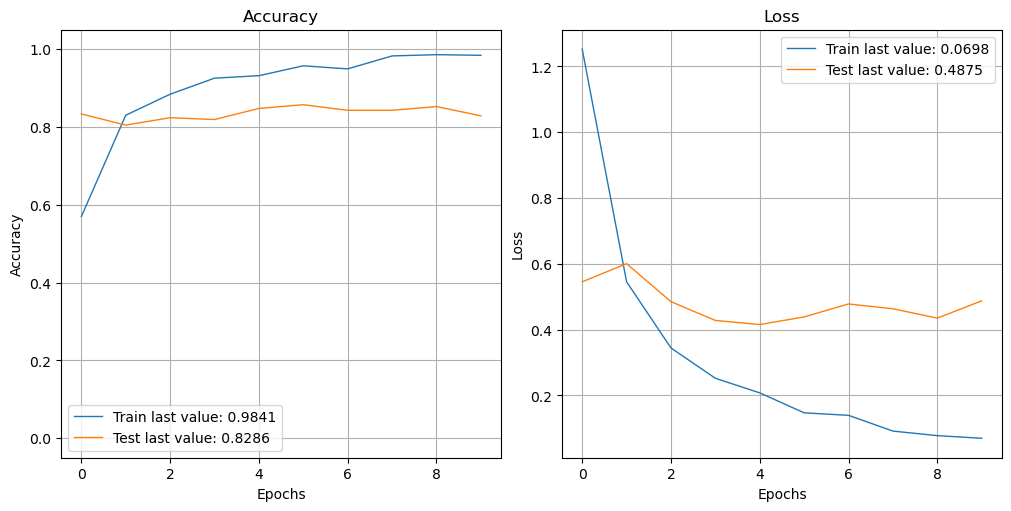

In [25]:
# Entraînement du modèle
model_densenet201, duration_densenet201 = train_model(model_densenet201, X_train_densenet201, y_train,
                                                      X_val_densenet201, y_val,
                                                      model_save_path="./model_densenet201_best.weights.h5")

In [26]:
# Évaluation du modèle
loss_densenet201, accuracy_densenet201, ari_score_densenet201 = evaluate_model(model_densenet201, X_train_densenet201,
                                                                               y_train, X_val_densenet201,
                                                                                y_val, X_test_densenet201, y_test,
                                                                               best_weights_path="./model_densenet201_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.9954 - loss: 0.0275
Training Accuracy after last epoch: 0.9952

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.8364 - loss: 0.4222
Test Accuracy after last epoch: 0.8333

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - accuracy: 0.8389 - loss: 0.4447
Validation Accuracy (best): 0.8476
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.8869 - loss: 0.3812
Test Accuracy (best): 0.8810
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step
Adjusted Rand Index (ARI): 0.7535


### Comparaison des résultats

In [27]:
# Initialisation de la liste pour stocker les résultats
data_results = []

# Fonction pour ajouter les résultats d'un modèle au DataFrame
def add_results(model_name, loss, accuracy, ari_score, duration):
    metrics = ['Loss', 'Accuracy', 'Adjusted Rand Score', 'Duration (en heures)']
    scores = [loss, accuracy, ari_score, (duration/3600)]
    for metric, score in zip(metrics, scores):
        data_results.append({
            'Model': model_name,
            'Metric': metric,
            'Score': score
        })

In [28]:
add_results('VGG16', loss_vgg16, accuracy_vgg16, ari_score_vgg16, duration_vgg16)
add_results('InceptionResNetV2', loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2, duration_iresnetv2)
add_results('DenseNet201', loss_densenet201, accuracy_densenet201, ari_score_densenet201, duration_densenet201)

data_metrics = pd.DataFrame(data_results)

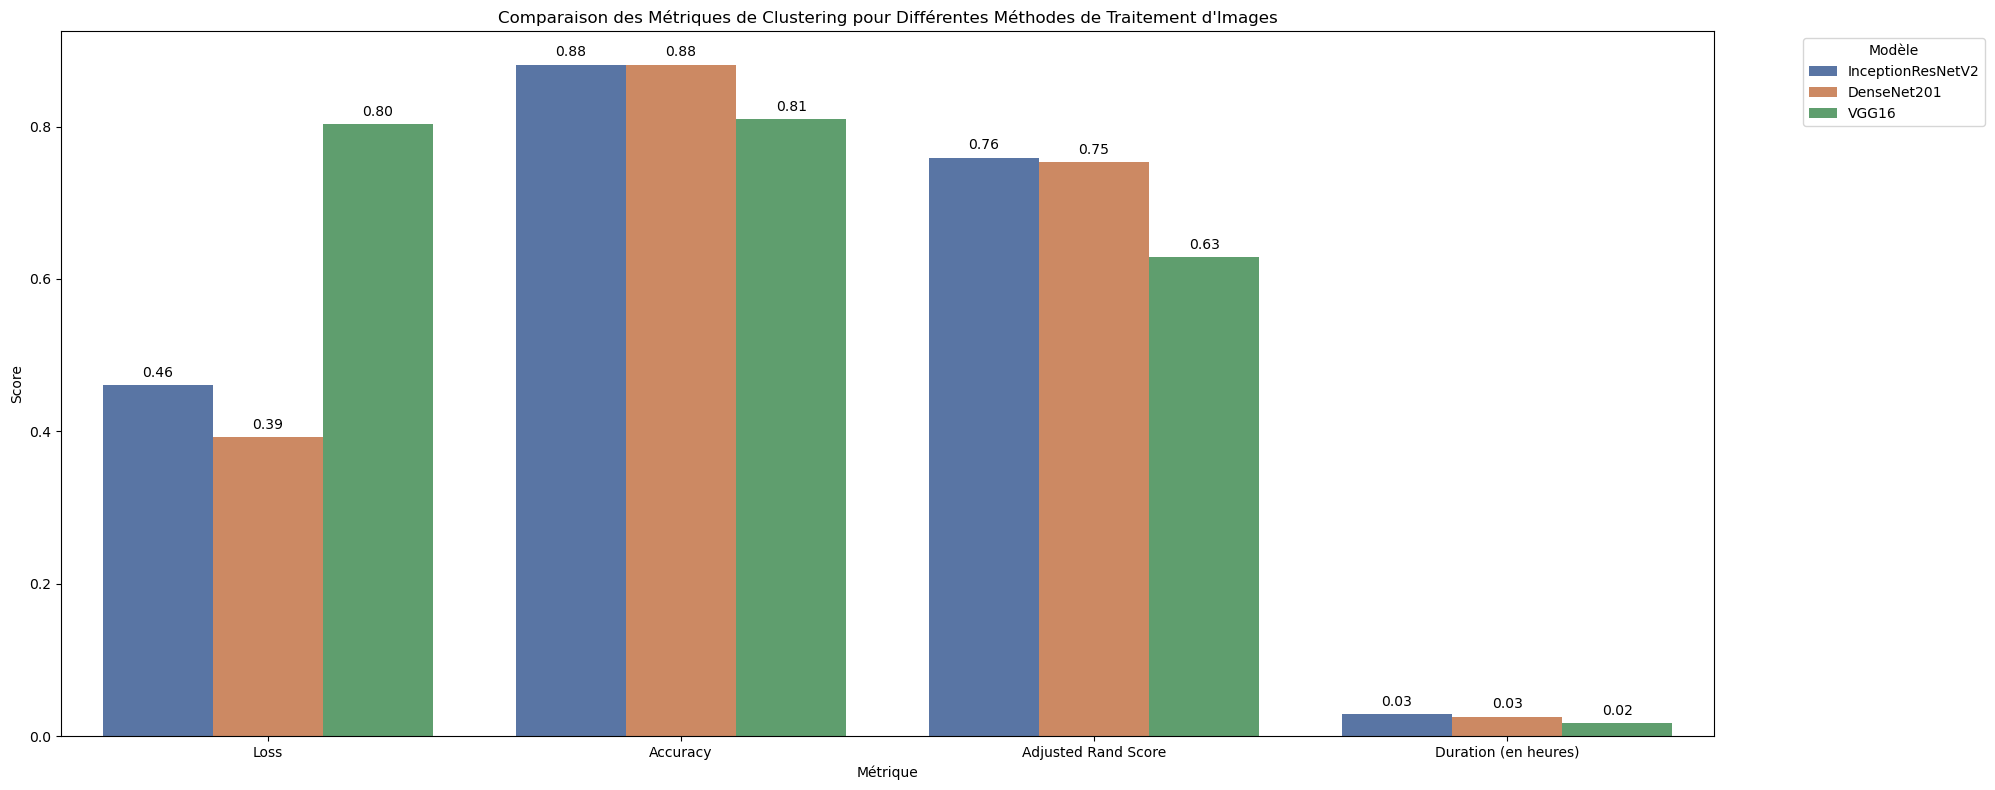

In [29]:
plot_model_performance(data_metrics)

# Optimisation

## Hyper paramètres

Testing with learning_rate=0.00075, batch_size=32, epochs=50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00015000000130385163.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 1.
Finished 0.00075, 32 with val_accuracy=0.8761904835700989, duration=144.7380509376526
Testing with learning_rate=0.00075, batch_size=64, epochs=50
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 1.
Finished 0.00075, 64 with val_accuracy=0.8619047403335571, duration=779.8898372650146
Testing with learning_rate=0.0005, batch_size=32, epochs=50

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 3.
Finished 0.0005, 32 with val_accuracy=0.8714285492897034, duration=576.0155282020569
Testing with learning_rate=

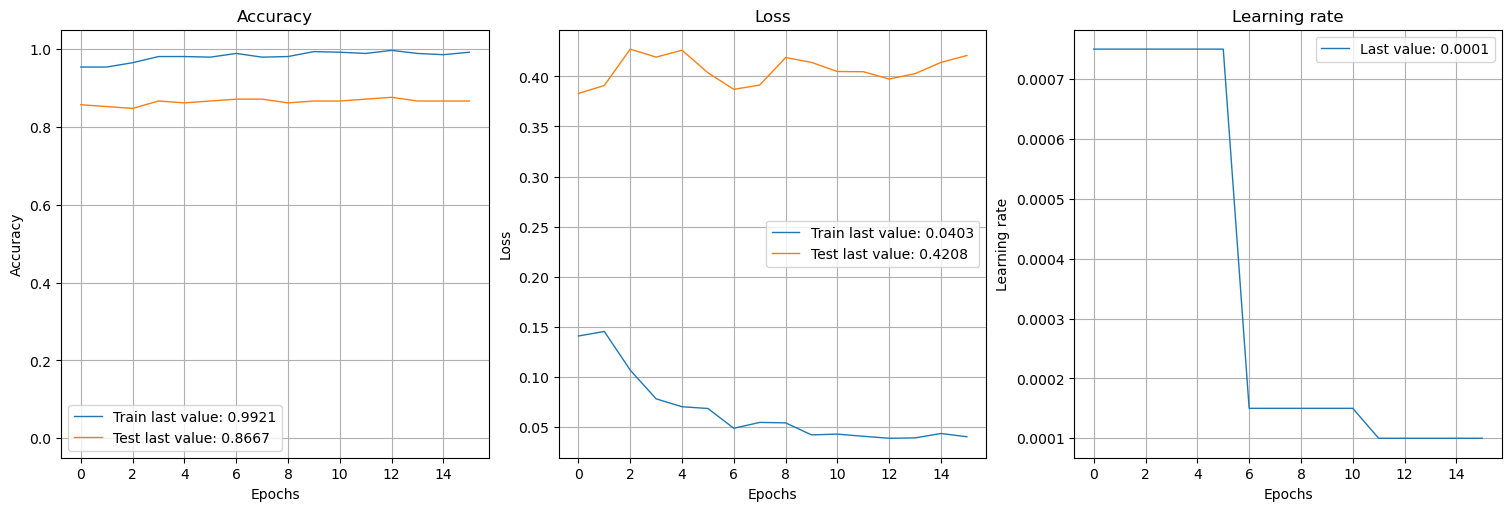

In [30]:
# Entraînement du modèle
best_model, duration_best = train_hyperparameters(model_iresnetv2, X_train_inceptionresnetv2, y_train, X_val_inceptionresnetv2,
                                                  y_val, "./model_best.weights.h5")

In [31]:
# Évaluation du modèle
loss_best, accuracy_best, ari_score_best = evaluate_model(best_model,
                                                          X_train_inceptionresnetv2,
                                                          y_train, X_val_inceptionresnetv2,
                                                          y_val, X_test_inceptionresnetv2,
                                                          y_test, best_weights_path="none")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8567 - loss: 0.4232
Validation Accuracy (best): 0.8571
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8832 - loss: 0.4359
Test Accuracy (best): 0.8810
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Adjusted Rand Index (ARI): 0.7654


In [32]:
add_results('InceptionResNetV2(HP)', loss_best, accuracy_best, ari_score_best, duration_best)
data_metrics = pd.DataFrame(data_results)

In [33]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,0.802919
1,VGG16,Accuracy,0.809524
2,VGG16,Adjusted Rand Score,0.628258
3,VGG16,Duration (en heures),0.016937
4,InceptionResNetV2,Loss,0.460391
5,InceptionResNetV2,Accuracy,0.880952
6,InceptionResNetV2,Adjusted Rand Score,0.758883
7,InceptionResNetV2,Duration (en heures),0.029073
8,DenseNet201,Loss,0.392329
9,DenseNet201,Accuracy,0.880952


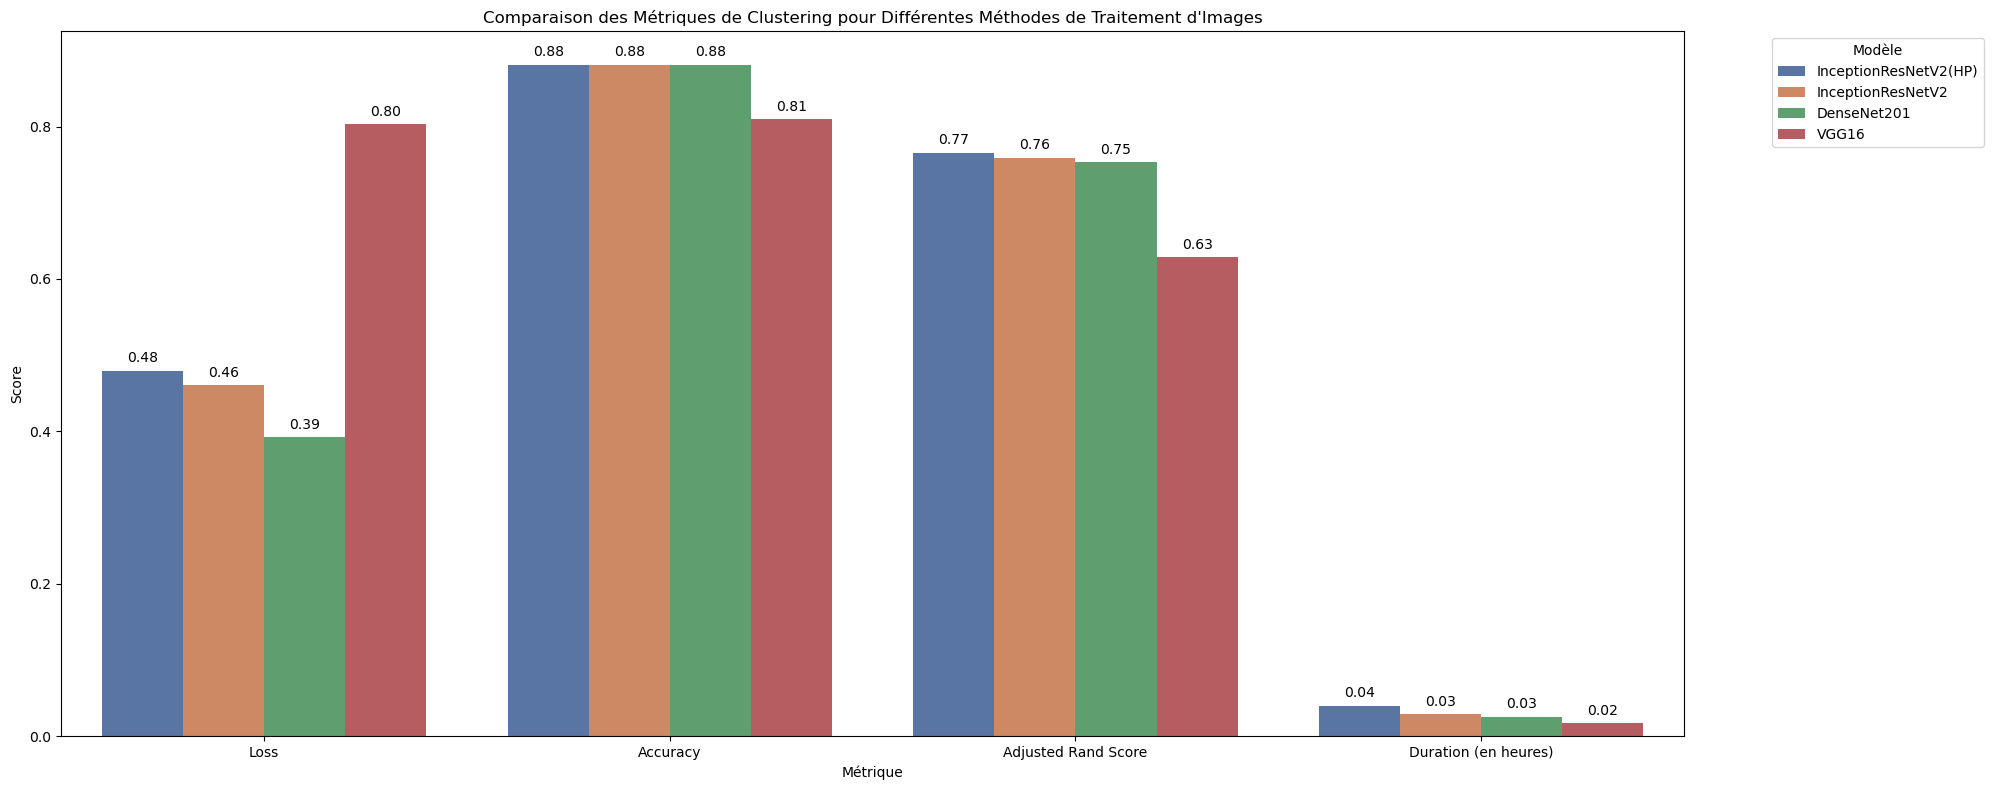

In [34]:
plot_model_performance(data_metrics)

## Data Augmentation

### ImageDataGenerator

In [35]:
train_generator= prepare_augmented_data(X_train_inceptionresnetv2, y_train)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9663 - loss: 0.1233
Epoch 1: val_loss improved from inf to 0.45728, saving model to ./model_augmented_data_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9656 - loss: 0.1240 - val_accuracy: 0.8381 - val_loss: 0.4573
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9617 - loss: 0.1507
Epoch 2: val_loss did not improve from 0.45728
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9614 - loss: 0.1516 - val_accuracy: 0.8381 - val_loss: 0.4896
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9659 - loss: 0.1148
Epoch 3: val_loss improved from 0.45728 to 0.42273, saving model to ./model_augmented_data_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9659 - loss: 0.1147 - val_accuracy: 0.8571 - val_loss: 0.4227
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9672 - loss: 0.0945
Epoch 4: val_loss did not improve from 0.42273
20/20 ━━━━━━━━━━━━━

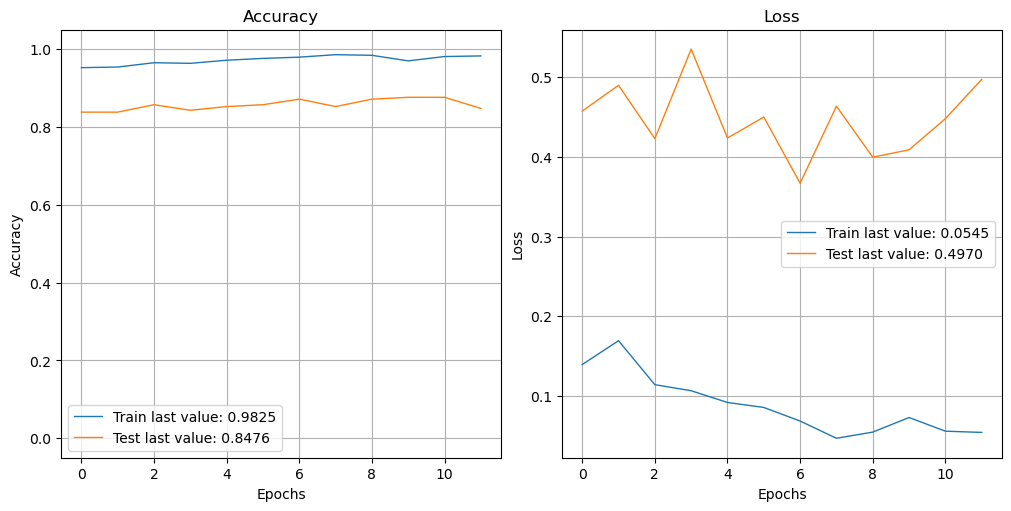

In [36]:
# Entraînement du modèle avec l'approche Sequential
model_augmented,  duration_augmented = train_model(model_iresnetv2,
                                                   train_generator.x, train_generator.y,
                                                   X_val_inceptionresnetv2, y_val,
                                                   "./model_augmented_data_best.weights.h5")

In [37]:
# Évaluation du modèle
loss_augmented, accuracy_augmented, ari_augmented = evaluate_model(model_augmented, train_generator.x, train_generator.y,
                                                                   X_val_inceptionresnetv2, y_val,
                                                                   X_test_inceptionresnetv2, y_test,
                                                                   "./model_augmented_data_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9954 - loss: 0.0196
Training Accuracy after last epoch: 0.9952

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8873 - loss: 0.5084
Test Accuracy after last epoch: 0.8714

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8759 - loss: 0.3559
Validation Accuracy (best): 0.8714
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8949 - loss: 0.4459
Test Accuracy (best): 0.8857
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Adjusted Rand Index (ARI): 0.7711


In [38]:
add_results('InceptionResNetV2(ImageDataGenerator)', loss_augmented, accuracy_augmented, ari_augmented,
            duration_augmented)
data_metrics = pd.DataFrame(data_results)

In [39]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,0.802919
1,VGG16,Accuracy,0.809524
2,VGG16,Adjusted Rand Score,0.628258
3,VGG16,Duration (en heures),0.016937
4,InceptionResNetV2,Loss,0.460391
5,InceptionResNetV2,Accuracy,0.880952
6,InceptionResNetV2,Adjusted Rand Score,0.758883
7,InceptionResNetV2,Duration (en heures),0.029073
8,DenseNet201,Loss,0.392329
9,DenseNet201,Accuracy,0.880952


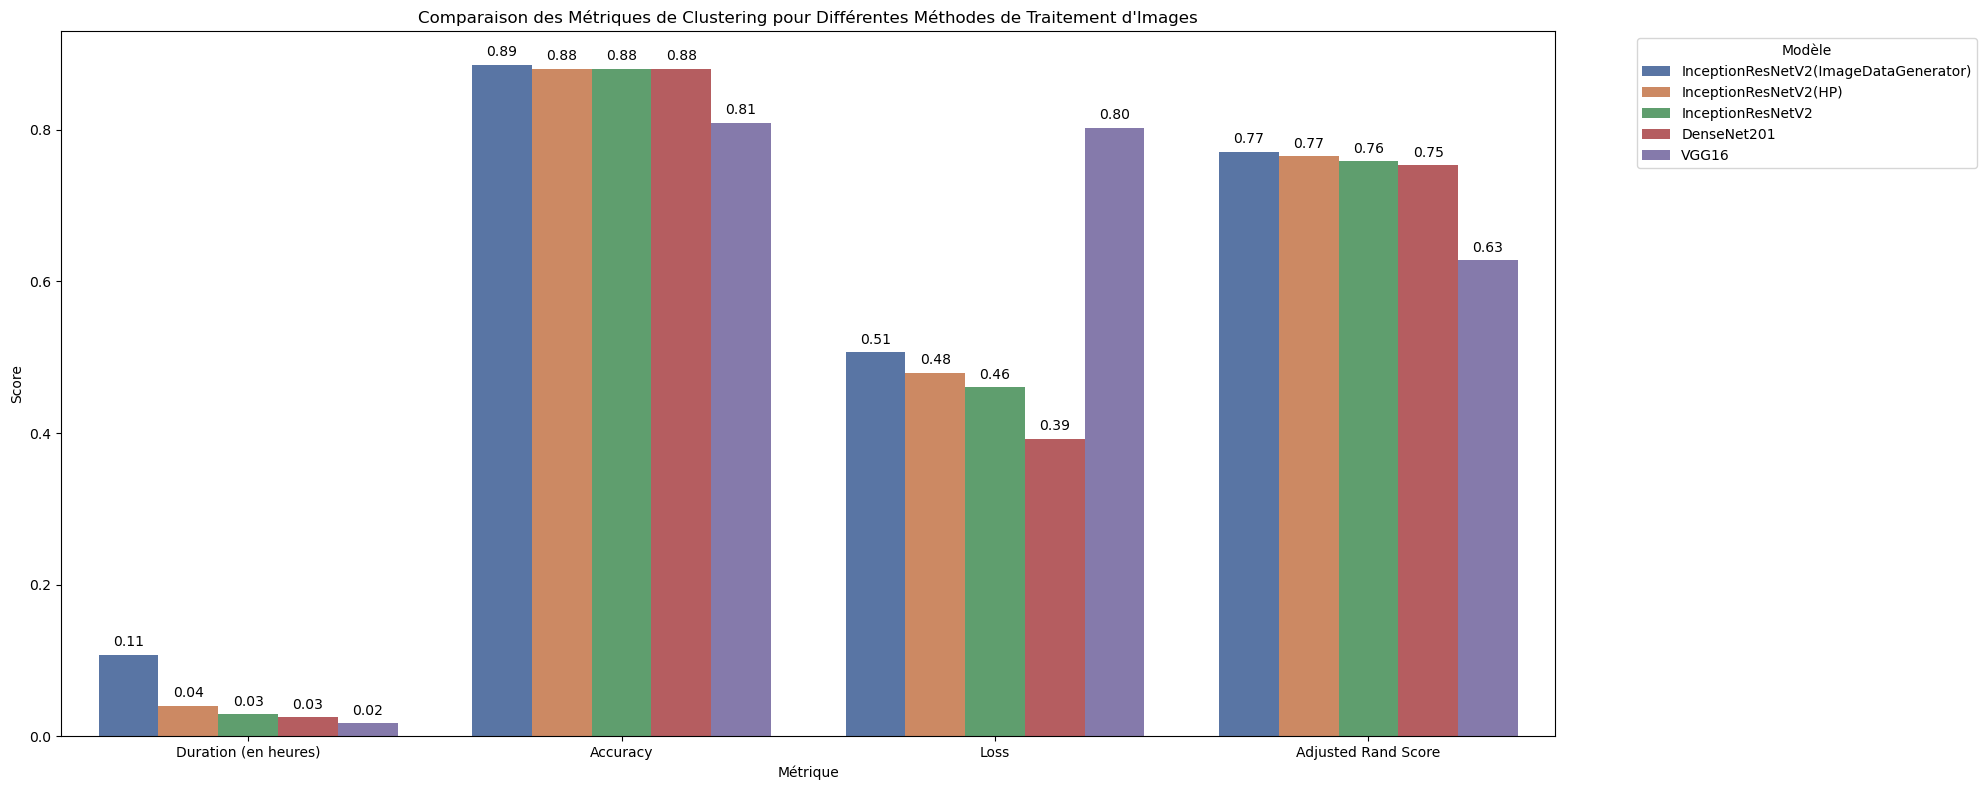

In [40]:
plot_model_performance(data_metrics)

### Sequential

In [41]:
# Préparation des données pour data augmentation
X_train, X_val, X_test = prepare_data_for_augmentation(paths_train, paths_val, paths_test, target_size=(299, 299))

In [42]:
# Création du modèle avec la data augmentation intégrée
seq_model = create_augmented_model()

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3715 - loss: 1.8017
Epoch 1: val_loss improved from inf to 0.70902, saving model to ./model_augmented_data_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3778 - loss: 1.7863 - val_accuracy: 0.7857 - val_loss: 0.7090
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7772 - loss: 0.7646
Epoch 2: val_loss improved from 0.70902 to 0.46799, saving model to ./model_augmented_data_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7777 - loss: 0.7624 - val_accuracy: 0.8571 - val_loss: 0.4680
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8426 - loss: 0.5519
Epoch 3: val_loss improved from 0.46799 to 0.42094, saving model to ./model_augmented_data_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8424 - loss: 0.5524 - val_accuracy: 0.8476 - val_loss: 0.4209
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8665 - loss: 0.4342
Epoch 

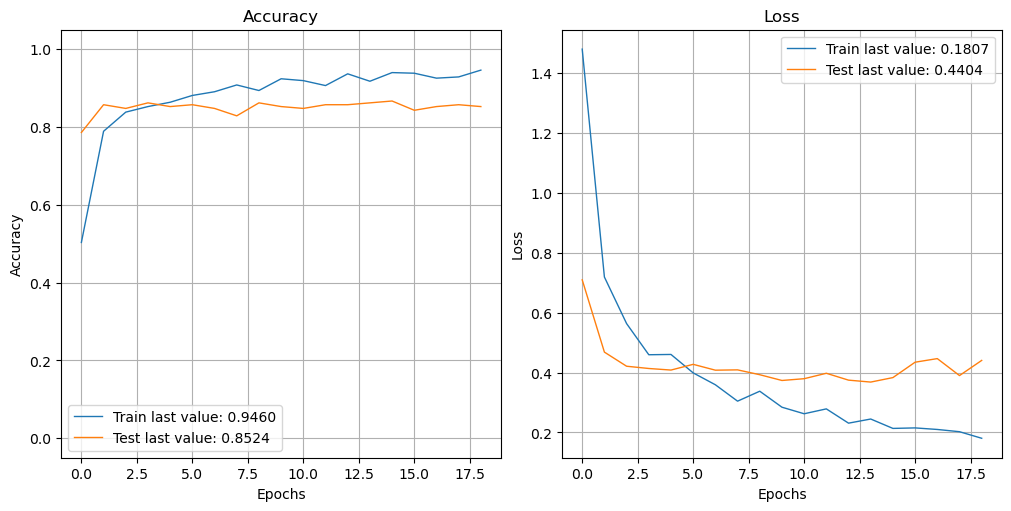

In [43]:
# Entraînement du modèle
seq_model, seq_duration = train_model(seq_model, X_train, y_train, X_val, y_val,
                                      "./model_augmented_data_best.weights.h5")

In [44]:
loss_with_sequential, accuracy_with_sequential, ari_score_with_sequential = evaluate_model(seq_model, X_train, y_train,
                                                                                           X_val, y_val, X_test, y_test,
                                                                                           "./model_augmented_data_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9798 - loss: 0.0984
Training Accuracy after last epoch: 0.9714

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8976 - loss: 0.4002
Test Accuracy after last epoch: 0.8714

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8463 - loss: 0.3844
Validation Accuracy (best): 0.8619
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8847 - loss: 0.3567
Test Accuracy (best): 0.8667
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Adjusted Rand Index (ARI): 0.7495


In [45]:
add_results('InceptionResNetV2(Sequential)', loss_with_sequential, accuracy_with_sequential, ari_score_with_sequential,
            seq_duration)
data_metrics = pd.DataFrame(data_results)

In [46]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,0.802919
1,VGG16,Accuracy,0.809524
2,VGG16,Adjusted Rand Score,0.628258
3,VGG16,Duration (en heures),0.016937
4,InceptionResNetV2,Loss,0.460391
5,InceptionResNetV2,Accuracy,0.880952
6,InceptionResNetV2,Adjusted Rand Score,0.758883
7,InceptionResNetV2,Duration (en heures),0.029073
8,DenseNet201,Loss,0.392329
9,DenseNet201,Accuracy,0.880952


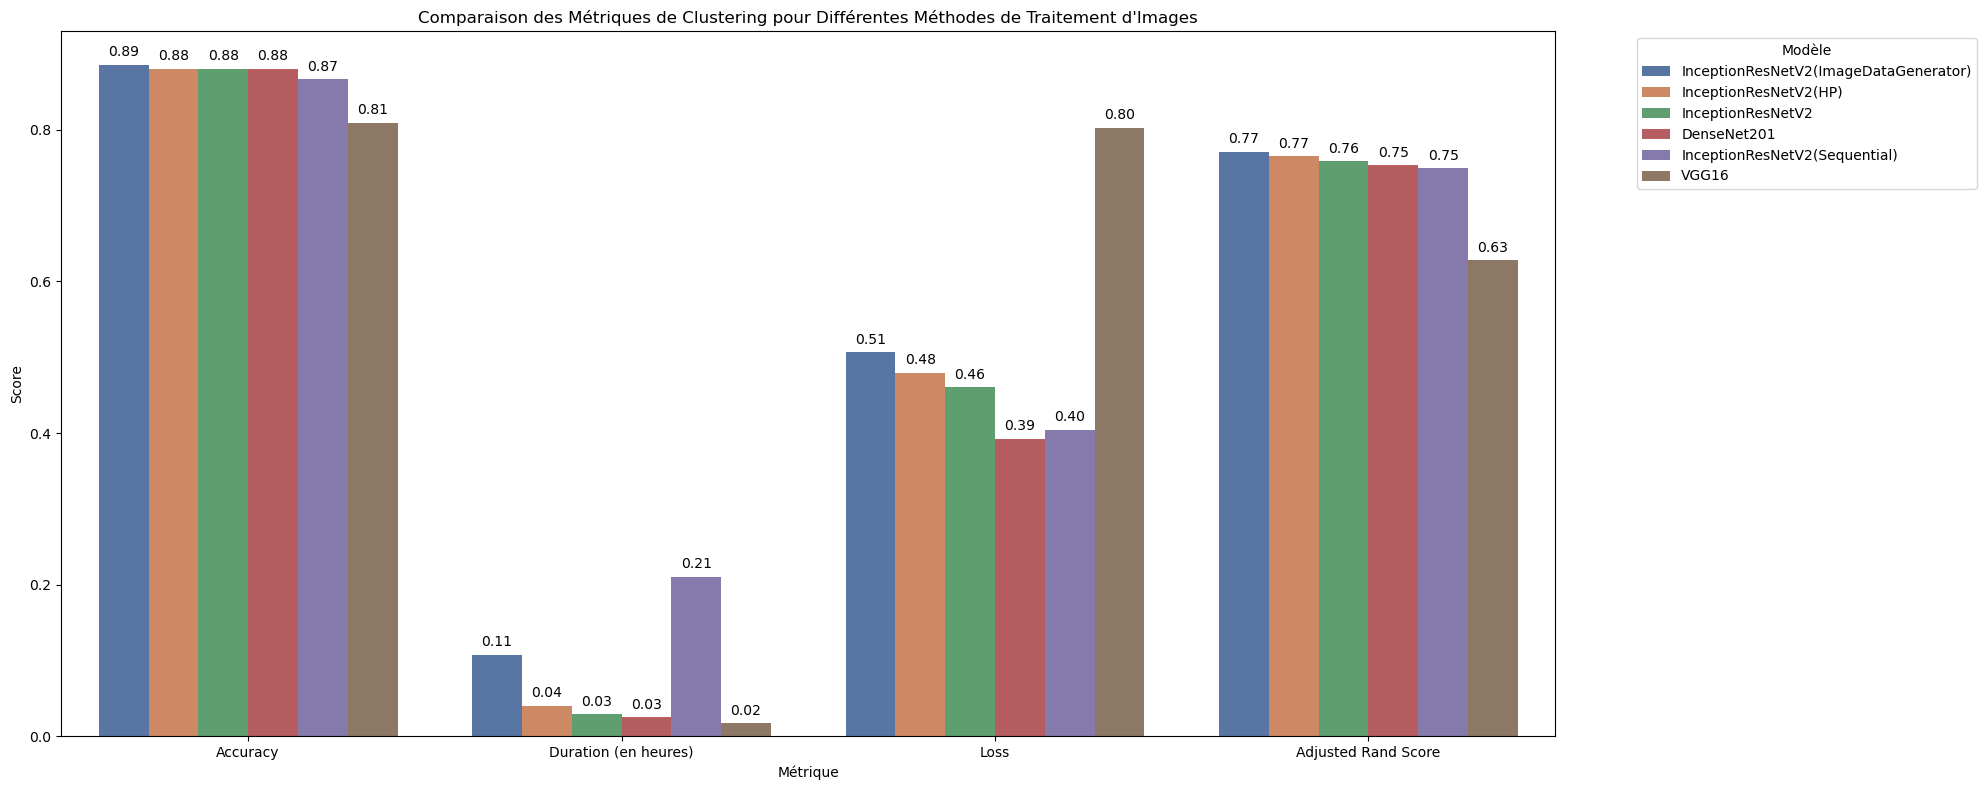

In [47]:
plot_model_performance(data_metrics)

### IA Generative

Utilisation de Copilot et du prompt :
"Créez une image haute résolution de [objet] sur un fond strictement blanc. Le sujet doit être vu de côté, montrant ses formes et caractéristiques distinctives. Assurez-vous que l'éclairage est parfaitement uniforme pour éliminer toutes les ombres sur le sujet et le fond. Le fond doit rester complètement blanc, sans nuances, textures ou autres éléments. L'image doit mettre en valeur uniquement le sujet, idéal pour des présentations de produit."

In [48]:
# Répertoires correspondant aux catégories
repertoires = {
    'Home Furnishing': "./data/Sources/generatedimages/homefurnishing",
    'Baby Care': "./data/Sources/generatedimages/baby",
    'Watches': "./data/Sources/generatedimages/watches",
    'Home Decor & Festive Needs': "./data/Sources/generatedimages/homedecor",
    'Kitchen & Dining': "./data/Sources/generatedimages/kitchen",
    'Beauty and Personal Care': "./data/Sources/generatedimages/beauty",
    'Computers': "./data/Sources/generatedimages/computers"
}

In [49]:
# Initialisation des listes pour les chemins d'image et les étiquettes
paths_train_gen = paths_train.copy()
y_train_gen = y_train.copy()

In [50]:
# Obtenir les catégories dans l'ordre d'encodage
categories = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Parcourir tous les répertoires
for categorie, repertoire in repertoires.items():
    # Récupérer l'indice de la catégorie dans l'encodage des catégories
    index_categorie = label_encoder.transform([categorie])[0]

    # Parcourir les images dans le répertoire
    for img in os.listdir(repertoire):
        # Créer le chemin complet de l'image
        chemin_image = os.path.join(repertoire, img)

        # Ajouter le chemin de l'image
        paths_train_gen.append(chemin_image)

        # Créer l'étiquette correspondante pour cette catégorie
        y_imggen_train = np.zeros(7)
        y_imggen_train[index_categorie] = 1

        # Ajouter l'étiquette
        y_train_gen = np.vstack([y_train_gen, y_imggen_train])

# Convertir les listes en tableaux numpy
paths_train_gen = np.array(paths_train_gen)

In [51]:
# Préparation des données
X_train_iresnetv2_ad, X_val_iresnetv2_ad, X_test_iresnetv2_ad = prepare_data(paths_train_gen, paths_val,
                                                                             paths_test, preprocess_inceptionresnetv2,
                                                                             target_size=(299, 299, 3))

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9455 - loss: 0.1611
Epoch 1: val_loss improved from inf to 0.47285, saving model to ./model_iresnetv2_ad_best.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9456 - loss: 0.1610 - val_accuracy: 0.8476 - val_loss: 0.4729
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9447 - loss: 0.1734
Epoch 2: val_loss improved from 0.47285 to 0.44959, saving model to ./model_iresnetv2_ad_best.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9447 - loss: 0.1736 - val_accuracy: 0.8571 - val_loss: 0.4496
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9513 - loss: 0.1361
Epoch 3: val_loss did not improve from 0.44959
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9517 - loss: 0.1348 - val_accuracy: 0.8524 - val_loss: 0.4777
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9714 - loss: 0.0922
Epoch 4: val_loss improved from 0.44959 to 0.40518, saving model to ./

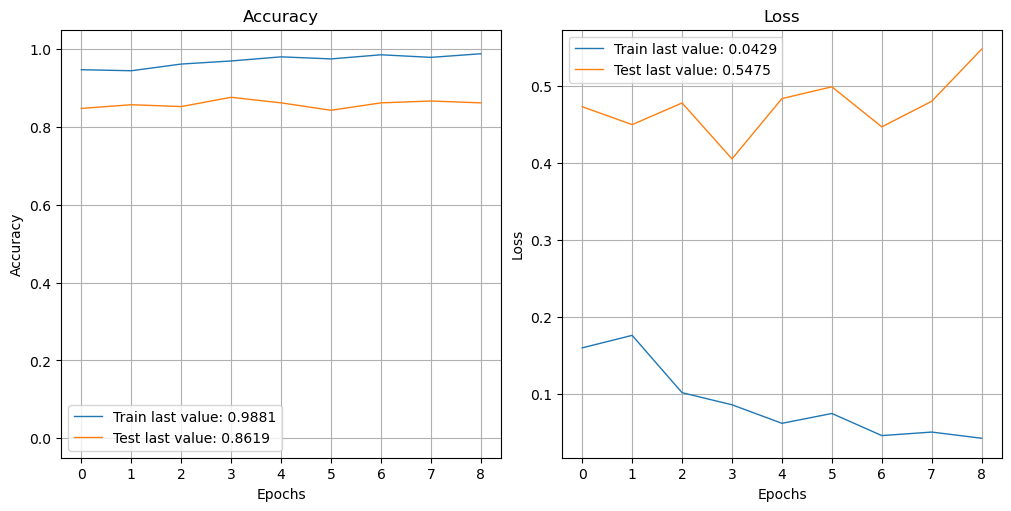

In [52]:
# Entraînement du modèle
model_iresnetv2_ad, duration_iresnetv2_ad = train_model(model_iresnetv2, X_train_iresnetv2_ad,
                                                        y_train_gen, X_val_iresnetv2_ad, y_val,
                                                        model_save_path="./model_iresnetv2_ad_best.weights.h5")

In [53]:
# Évaluation du modèle
loss_iresnetv2_ad, accuracy_iresnetv2_ad, ari_score_iresnetv2_ad = evaluate_model(model_iresnetv2_ad,
                                                                                  X_train_iresnetv2_ad,
                                                                                  y_train_gen, X_val_iresnetv2_ad,
                                                                                  y_val, X_test_iresnetv2_ad,
                                                                                  y_test,
                                                                                  best_weights_path="./model_iresnetv2_ad_best.weights.h5")

24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9962 - loss: 0.0164
Training Accuracy after last epoch: 0.9974

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8805 - loss: 0.6346
Test Accuracy after last epoch: 0.8762

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8768 - loss: 0.4055
Validation Accuracy (best): 0.8762
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8886 - loss: 0.4434
Test Accuracy (best): 0.8857
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Adjusted Rand Index (ARI): 0.7754


In [54]:
add_results('InceptionResNetV2(IA Generative)', loss_iresnetv2_ad, accuracy_iresnetv2_ad,
            ari_score_iresnetv2_ad, duration_iresnetv2_ad)
data_metrics = pd.DataFrame(data_results)

In [55]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,0.802919
1,VGG16,Accuracy,0.809524
2,VGG16,Adjusted Rand Score,0.628258
3,VGG16,Duration (en heures),0.016937
4,InceptionResNetV2,Loss,0.460391
5,InceptionResNetV2,Accuracy,0.880952
6,InceptionResNetV2,Adjusted Rand Score,0.758883
7,InceptionResNetV2,Duration (en heures),0.029073
8,DenseNet201,Loss,0.392329
9,DenseNet201,Accuracy,0.880952


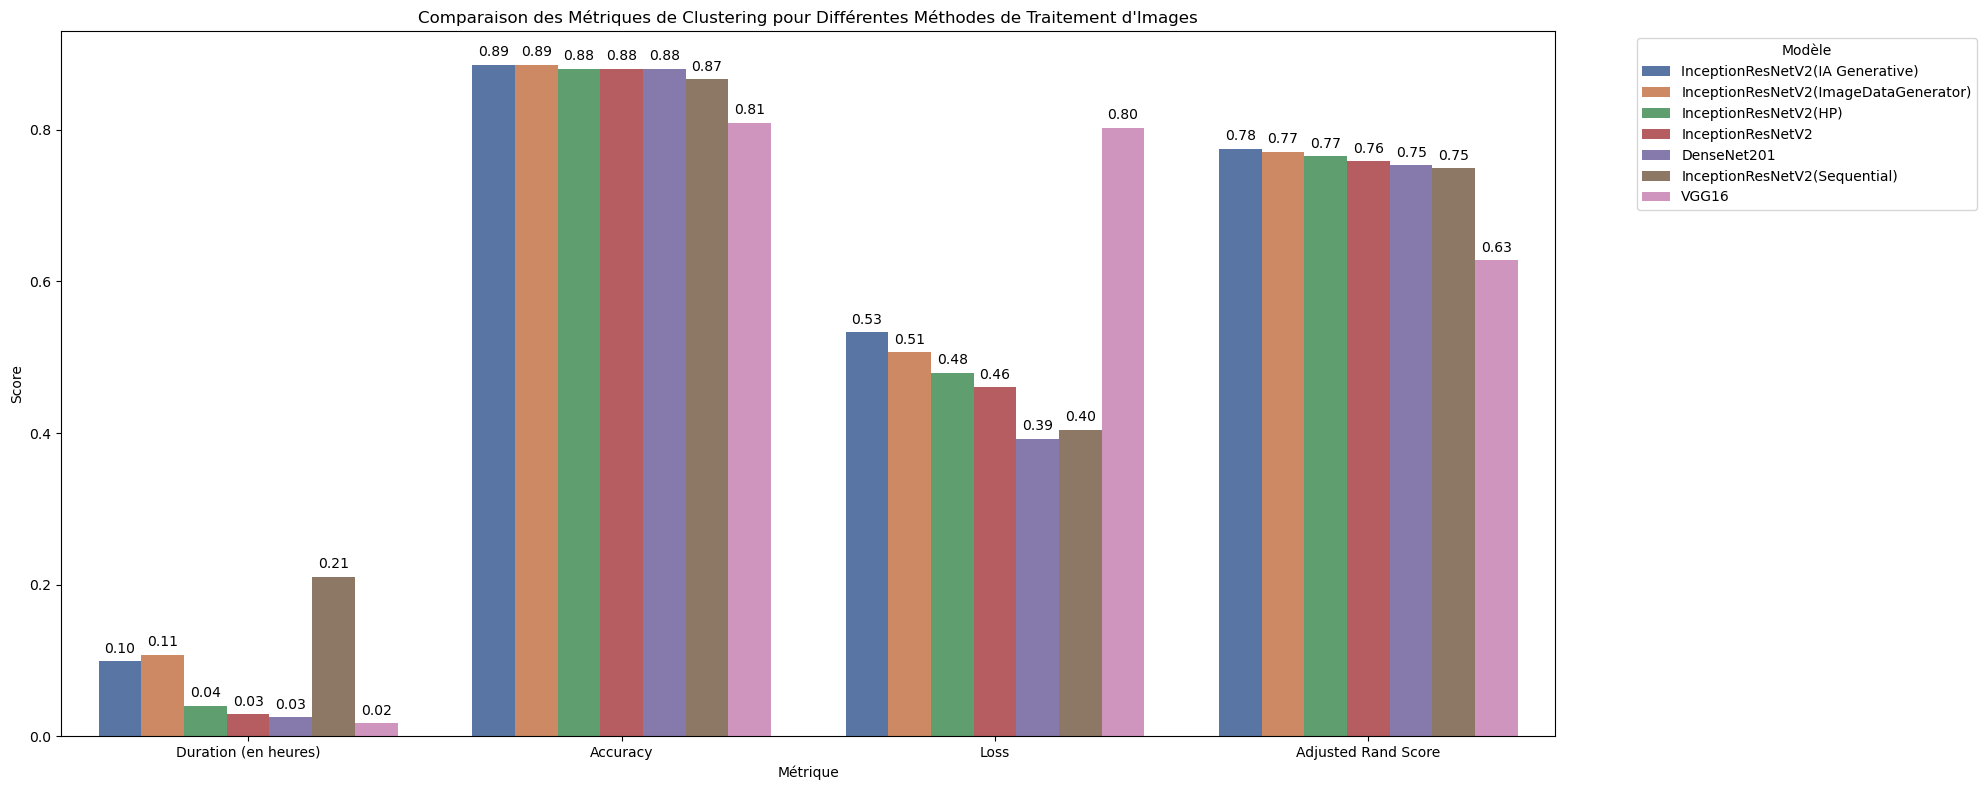

In [56]:
plot_model_performance(data_metrics)